## Generalized Additive Models, Logistic regression for RSV serology. ##
Authors: Stijn Andeweg, Jan van de Kassteele and Michiel van Boven

In [1]:
# Load packages
library(mgcv)
library(ggplot2)
library(tidyverse)
library(lubridate)
library(gridExtra)
library(grid)
library(writexl)

Loading required package: nlme

This is mgcv 1.8-40. For overview type 'help("mgcv-package")'.

Warning message:
"package 'ggplot2' was built under R version 4.2.0"
Warning message:
"package 'tidyverse' was built under R version 4.2.0"
-- Attaching packages ------------------------------------------------------------------------------- tidyverse 1.3.1 --

v tibble  3.1.6     v dplyr   1.0.7
v tidyr   1.1.4     v stringr 1.4.0
v readr   2.1.2     v forcats 0.5.1
v purrr   0.3.4     

Warning message:
"package 'stringr' was built under R version 4.2.0"
Warning message:
"package 'forcats' was built under R version 4.2.0"
-- Conflicts ---------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::collapse() masks nlme::collapse()
x dplyr::filter()   masks stats::filter()
x dplyr::lag()      masks stats::lag()


Attaching package: 'lubridate'


The following objects are masked from 'package:base':

    date, intersect, setdiff, union


W

In [2]:
folder <- "RSV_serology"
PATH <- file.path("C:/Users/julia/OneDrive - London School of Hygiene and Tropical Medicine/Documents/LSHTM/Project") #"/home/andewegs/1_RSV_scripts/"
setwd(PATH)
getwd()

[1] "C:/Users/julia/OneDrive - London School of Hygiene and Tropical Medicine/Documents/LSHTM/Project"

In [3]:
figure_folder <- '/home/andewegs/1_RSV_scripts/tensor_splines/figures/final_models/'

# set colors in figures
color_1 = '#0072B2' #Blue
color_2 = '#E69F00' #Orange

## DATA ##

In [4]:
rsv.data_org <- read_csv(file = "Data/infection_status.csv")

Rows: 682 Columns: 23
-- Column specification ------------------------------------------------------------------------------------------------
Delimiter: ","
dbl  (20): age_days, infection, IgG_PreF, IgA_PreF, IgG_PostF, IgA_PostF, Ig...
lgl   (1): IgA_Nn_household
date  (2): birthday, consultdate

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [5]:
season_border = "10-01" #MM-DD
# Some modifications
rsv.data <- rsv.data_org %>%
  # Get day of the year of birthday (= number between 1 and 365)
  mutate(
    Birth_doy = birthday %>% yday()
  ) %>%
  # Alter number of housefold members 1 == no siblings, >1 == having siblings
  mutate(
    household04_counts = case_when(
      age_days/365 >= 5 ~ (household04 + 1),  #because the child itself is also included in household size
      age_days/365 < 5 ~ household04)       #the household04 of children of age 5 should also include the child itself
  ) %>%
  # Make number of siblings 0-4 years binary factor variable
  mutate(
    Siblings04 = case_when(
      household04_counts <= 1 ~ 'False',
      household04_counts > 1 ~ 'True'
    ) %>% 
      factor()
  ) %>%
  # Make number of siblings 5-9 years binary factor variable
  mutate(
    Siblings59 = case_when(
      household59 <= 0 ~ 'False',
      household59 > 0 ~ 'True'
    ) %>% 
      factor()
  ) %>% 
  # Set nursery 0 1 to False True
  mutate(
    Nursery = case_when(
      visitnursery_child == 0 ~ 'False',
      visitnursery_child == 1 ~ 'True'
    ) %>% 
      factor()
  ) %>% 
  # Set variable for the different seasons.
  mutate(seasons = case_when(
    consultdate < paste("2006-", season_border, sep = "")  ~ "2005/2006", 
    (consultdate >= paste("2006-", season_border, sep = "") &  consultdate < "2010-01-01") ~ "2006/2007",
    (consultdate >= "2010-01-01" &  consultdate < paste("2016-", season_border, sep = "")) ~ "2015/2016",
    consultdate >= paste("2016-", season_border, sep = "")  ~ "2016/2017")
  ) %>% 
  # Variable for the two cohorts
  mutate(
    cohort = if_else(seasons == "2005/2006" | seasons == "2006/2007", "2006/2007", "2016/2017"))

# Only keep data with the variables of intrest n = 616
completeVec <- complete.cases(rsv.data[, c("Siblings04", "Nursery")])
rsv.data <- rsv.data[completeVec,]

In [18]:
rsv.data$consultdate[30:40]

[1] "2006-08-21" "2006-08-30" "2006-08-30" "2006-09-11" "2006-09-18"
 [6] "2006-09-27" "2006-10-04" "2006-10-04" "2006-10-11" "2006-10-11"
[11] "2006-10-11"

In [19]:
rsv.data$seasons[30:40]

[1] "2005/2006" "2005/2006" "2005/2006" "2005/2006" "2005/2006" "2005/2006"
 [7] "2006/2007" "2006/2007" "2006/2007" "2006/2007" "2006/2007"

In [10]:
head(rsv.data$cohort)

[1] "2006/2007" "2006/2007" "2006/2007" "2006/2007" "2006/2007" "2006/2007"

In [20]:
nrow(rsv.data)

[1] 616

## Analysis ##

**Model 1 with age and birth doy**

In [6]:
model1 <- gam(
  formula = infection ~ 
    ti(age_days, bs = "ps", k = 25) +  #definition of tensor product smooths and interactions within gam model formulae. te produces a full tensor product smooth, while ti produces a tensor product interaction, appropriate when the main effects (and any lower interactions) are also present.
    ti(Birth_doy, bs = "cp", k = 11),# +
  #ti(age_days, Birth_doy, bs = c("ps", "cp")),
  knots = list(Birth_doy = c(1, 365)),
  family = binomial,
  method = "REML",  #restricted maximum likelihood 
  data = rsv.data)
summary(model1)

Warning message in smooth.construct.tensor.smooth.spec(object, dk$data, dk$knots):
"reparameterization unstable for margin: not done"



Family: binomial 
Link function: logit 

Formula:
infection ~ ti(age_days, bs = "ps", k = 25) + ti(Birth_doy, bs = "cp", 
    k = 11)

Parametric coefficients:
            Estimate Std. Error z value Pr(>|z|)
(Intercept)    1.714      1.291   1.328    0.184

Approximate significance of smooth terms:
                edf Ref.df Chi.sq p-value    
ti(age_days)  3.000      3 140.08 < 2e-16 ***
ti(Birth_doy) 2.252     10  11.13 0.00218 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

R-sq.(adj) =  0.538   Deviance explained = 48.5%
-REML = 217.93  Scale est. = 1         n = 616

In [7]:
# Generate some fake data for the model prediction
rsv.preddata <- expand.grid(
  age_days = as.matrix(c(30,60,90,120,150,180,270,365,547,730,900,1095)),
  Birth_doy = seq(from = 1, to = 365, by = 1))

In [8]:
# Make predictions for each combination using the GAM model
# Do this in a temporary tibble, because two columns are produced: fit and se.fit
tmp <- predict(
  object = model1,
  newdata = rsv.preddata,
  type = "link",
  se.fit = TRUE) %>%
  as_tibble

In [9]:
# Bind tmp to rsv.preddata and calculate the p_inf including 95% lower and upper bound
rsv.doy_age.preddata <- bind_cols(rsv.preddata, tmp) %>%
  mutate(
    fit_lwr = fit + qnorm(0.025)*se.fit,   
    fit_upr = fit + qnorm(0.975)*se.fit,
    p_inf = fit %>% plogis,                #create vector of probabilities from log odds
    p_inf_lwr = fit_lwr %>% plogis,
    p_inf_upr = fit_upr %>% plogis)

Saving 6.67 x 6.67 in image



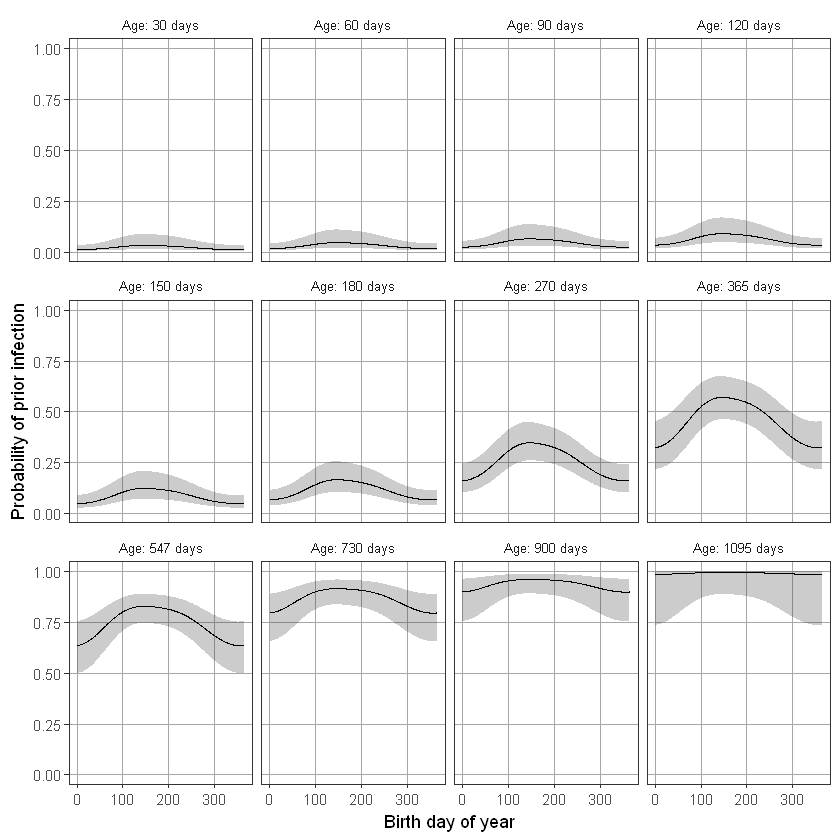

In [10]:
#Plot results
doy_age <- ggplot(
  data = rsv.doy_age.preddata,
  mapping = aes(
    x = Birth_doy, y = p_inf, ymin = p_inf_lwr, ymax = p_inf_upr)) +
  geom_ribbon(
    alpha = 0.25) +
  geom_line() +
  ylab("Probability of prior infection") +
  xlab("Birth day of year") +
  facet_wrap(
    facets = ~ age_days, labeller = labeller(age_days = 
                                               c("30" = "Age: 30 days",
                                                 "60" = "Age: 60 days",
                                                 "90" = "Age: 90 days",
                                                 "120" = "Age: 120 days",
                                                 "150" = "Age: 150 days",
                                                 "180" = "Age: 180 days",
                                                 "270" = "Age: 270 days",
                                                 "365" = "Age: 365 days",
                                                 "547" = "Age: 547 days",
                                                 "730" = "Age: 730 days",
                                                 "900" = "Age: 900 days",
                                                 "1095" = "Age: 1095 days"))
  ) + theme_bw() + 
  theme(panel.grid.minor = element_blank(),panel.grid.major = element_line(colour = "grey65", size = 0.2),
        strip.background = element_rect(
          color="black", fill="white", linetype = "blank"),
        strip.text = element_text(size=8)
  )

doy_age
ggsave(file = file.path(PATH, 'age_doy.svg'), plot = doy_age)

In [11]:
# Model1 for age time steps of 73 days
rsv.preddata <- expand.grid(
  age_days = as.matrix(c(73,146,219,292,365,
                         73+365,146+365,219+365,292+365,365+365,
                         73+365+365,146+365+365,219+365+365,292+365+365,365+365+365)),
  Birth_doy = seq(from = 1, to = 365, by = 5))

In [12]:
# Make predictions for each combination using the GAM model
# Do this in a temporary tibble, because two columns are produced: fit and se.fit
tmp <- predict(
  object = model1,
  newdata = rsv.preddata,
  type = "link",
  se.fit = TRUE) %>%
  as_tibble

In [14]:
# Bind tmp to rsv.preddata and calculate the p_inf including 95% lower and upper bound
rsv.doy_age.preddata_eqstep <- bind_cols(rsv.preddata, tmp) %>%
  mutate(
    fit_lwr = fit + qnorm(0.025)*se.fit,   
    fit_upr = fit + qnorm(0.975)*se.fit,
    p_inf = fit %>% plogis,                #create vector of probabilities from log odds
    p_inf_lwr = fit_lwr %>% plogis,
    p_inf_upr = fit_upr %>% plogis)

Saving 6.67 x 6.67 in image



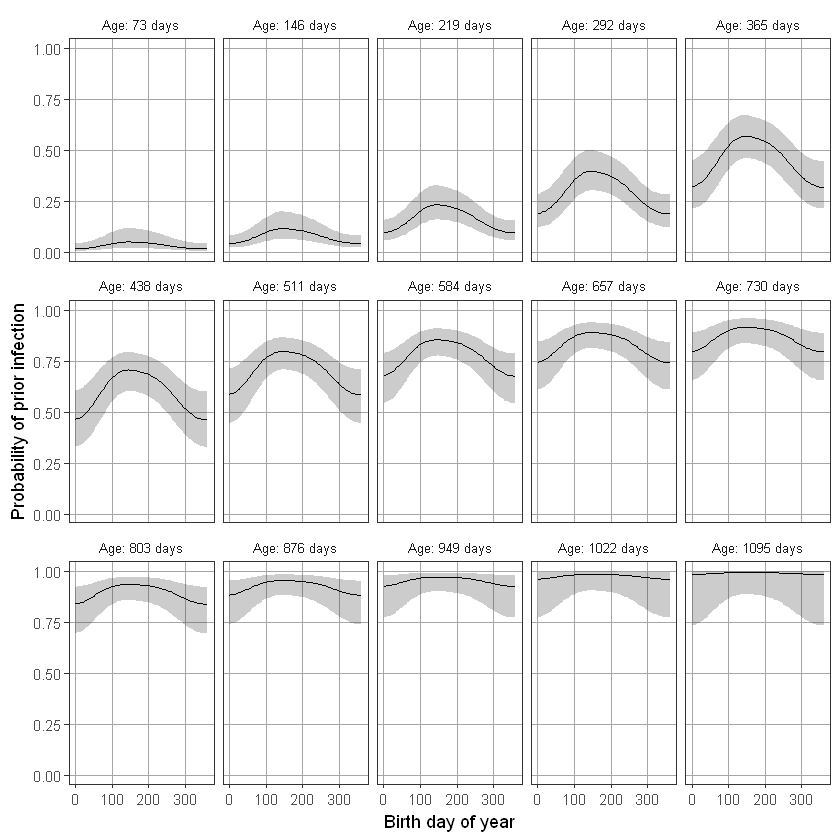

In [15]:
# Plot results ----

# Plot Supplement figure
doy_age_73 <- ggplot(
  data = rsv.doy_age.preddata_eqstep,
  mapping = aes(
    x = Birth_doy, y = p_inf, ymin = p_inf_lwr, ymax = p_inf_upr)) +
  geom_ribbon(
    alpha = 0.25) +
  geom_line() +
  ylab("Probability of prior infection") +
  xlab("Birth day of year") +
  facet_wrap(facets = ~ age_days, ncol = 5, labeller = labeller(age_days = 
                                                                  c("73" = "Age: 73 days",
                                                                    "146" = "Age: 146 days",
                                                                    "219" = "Age: 219 days",
                                                                    "292" = "Age: 292 days",
                                                                    "365" = "Age: 365 days",
                                                                    "438" = "Age: 438 days",
                                                                    "511" = "Age: 511 days",
                                                                    "584" = "Age: 584 days",
                                                                    "657" = "Age: 657 days",
                                                                    "730" = "Age: 730 days",
                                                                    "803" = "Age: 803 days",
                                                                    "876" = "Age: 876 days",
                                                                    "949" = "Age: 949 days",
                                                                    "1022" = "Age: 1022 days",
                                                                    "1095" = "Age: 1095 days"))) + 
  theme_bw() + 
  theme(panel.grid.minor = element_blank(),panel.grid.major = element_line(colour = "grey65", size = 0.2),
        strip.background = element_rect(
          color="black", fill="white", linetype = "blank"),
        strip.text = element_text(size=8)
  )

doy_age_73
ggsave(file = file.path(PATH, 'age_doy_15grid.svg'), plot = doy_age_73)

**Model 2 with with age, birth doy and Siblings04**

In [18]:
model2 <- gam(
  formula = infection ~ 
    Siblings04 + 
    ti(Birth_doy, bs = "cp", k = 11) + 
    ti(age_days, bs = "ps", k = 25),# +
  #ti(age_days, bs = "ps", k = 15, by = Siblings04),
  knots = list(birth_doy = c(1, 365)),
  family = binomial,
  method = "REML",  #restricted maximum likelihood 
  data = rsv.data)
summary(model2)

Warning message in smooth.construct.tensor.smooth.spec(object, dk$data, dk$knots):
"reparameterization unstable for margin: not done"



Family: binomial 
Link function: logit 

Formula:
infection ~ Siblings04 + ti(Birth_doy, bs = "cp", k = 11) + ti(age_days, 
    bs = "ps", k = 25)

Parametric coefficients:
               Estimate Std. Error z value Pr(>|z|)  
(Intercept)      1.5587     1.3232   1.178   0.2388  
Siblings04True   0.5116     0.2445   2.092   0.0364 *
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Approximate significance of smooth terms:
                edf Ref.df Chi.sq p-value    
ti(Birth_doy) 2.259     10  11.48  0.0018 ** 
ti(age_days)  3.000      3 140.52  <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

R-sq.(adj) =  0.539   Deviance explained =   49%
-REML = 216.15  Scale est. = 1         n = 616

Saving 6.67 x 6.67 in image



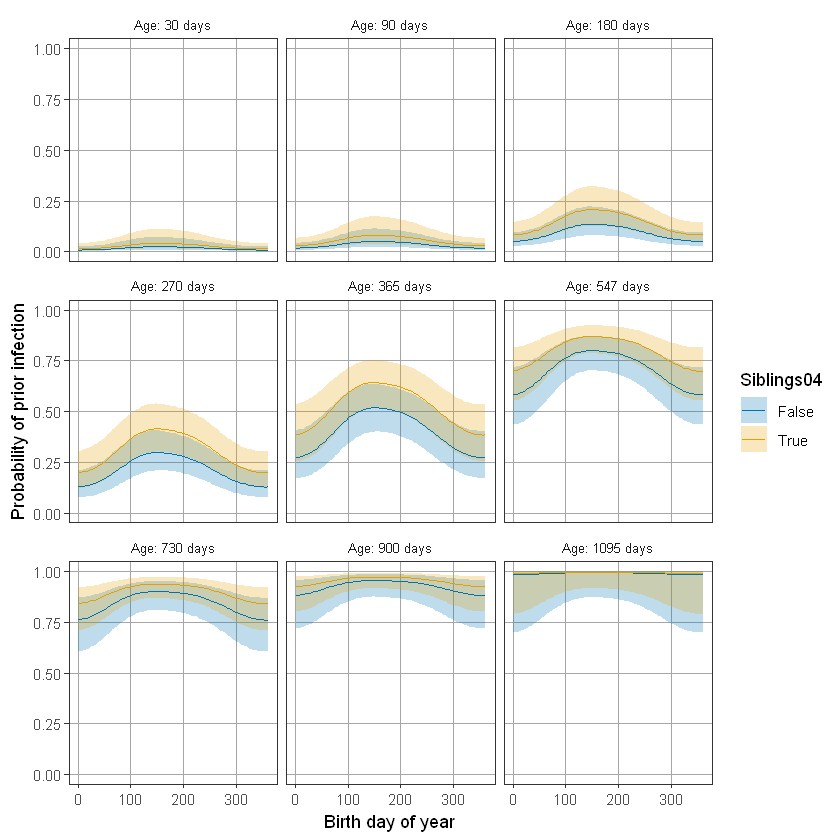

In [19]:
# Generate some fake data for the model prediction
rsv.preddata <- expand.grid(
  age_days = c(30,90,180,270,365,547,730,900,1095),
  Birth_doy = seq(from = 1, to = 365, by = 5),
  Siblings04 = factor(c('True', 'False')))

# Make predictions for each combination using the GAM model
# Do this in a temporary tibble, because two columns are produced: fit and se.fit
tmp <- predict(
  object = model2,
  newdata = rsv.preddata,
  type = "link",
  se.fit = TRUE) %>%
  as_tibble

# Bind tmp to rsv.preddata and calculate the p_inf including 95% lower and upper bound
rsv.doy_age_sib.preddata <- bind_cols(rsv.preddata, tmp) %>%
  mutate(
    fit_lwr = fit + qnorm(0.025)*se.fit,   
    fit_upr = fit + qnorm(0.975)*se.fit,
    p_inf = fit %>% plogis,                #create vector of probabilities from log odds
    p_inf_lwr = fit_lwr %>% plogis,
    p_inf_upr = fit_upr %>% plogis)

#
# Plot results ----
#

# Plot Supplement Figure
doy_age_sib <- ggplot(
  data = rsv.doy_age_sib.preddata,
  mapping = aes(
    x = Birth_doy, y = p_inf, ymin = p_inf_lwr, ymax = p_inf_upr,
    group = Siblings04, fill = Siblings04, color = Siblings04
  )) +
  geom_ribbon(
    alpha = 0.25, colour = NA) +
  geom_line() +
  scale_fill_manual(values=c(color_1, color_2)) + 
  scale_color_manual(values=c(color_1, color_2)) + 
  ylab("Probability of prior infection") +
  xlab("Birth day of year") +
  facet_wrap(
    facets = ~ age_days, labeller = labeller(age_days = 
                                               c("30" = "Age: 30 days",
                                                 "90" = "Age: 90 days",
                                                 "180" = "Age: 180 days",
                                                 "270" = "Age: 270 days",
                                                 "365" = "Age: 365 days",
                                                 "547" = "Age: 547 days",
                                                 "730" = "Age: 730 days",
                                                 "900" = "Age: 900 days",
                                                 "1095" = "Age: 1095 days"))
  )  + theme_bw() + 
  theme(panel.grid.minor = element_blank(),panel.grid.major = element_line(colour = "grey65", size = 0.2),
        strip.background = element_rect(
          color="black", fill="white", linetype = "blank"),
        strip.text = element_text(size=8)
  )

doy_age_sib
ggsave(file = file.path(PATH, 'age_doy_sib.svg'), plot = doy_age_sib)

Warning message in smooth.construct.tensor.smooth.spec(object, dk$data, dk$knots):
"reparameterization unstable for margin: not done"



Family: binomial 
Link function: logit 

Formula:
infection ~ Siblings59 + ti(Birth_doy, bs = "cp", k = 11) + ti(age_days, 
    bs = "ps", k = 25)

Parametric coefficients:
               Estimate Std. Error z value Pr(>|z|)
(Intercept)      1.6757     1.2950   1.294    0.196
Siblings59True   0.2292     0.2845   0.806    0.420

Approximate significance of smooth terms:
                edf Ref.df Chi.sq p-value    
ti(Birth_doy) 2.239     10   11.1 0.00216 ** 
ti(age_days)  3.000      3  138.5 < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

R-sq.(adj) =  0.537   Deviance explained = 48.6%
-REML = 217.94  Scale est. = 1         n = 616

Saving 6.67 x 6.67 in image



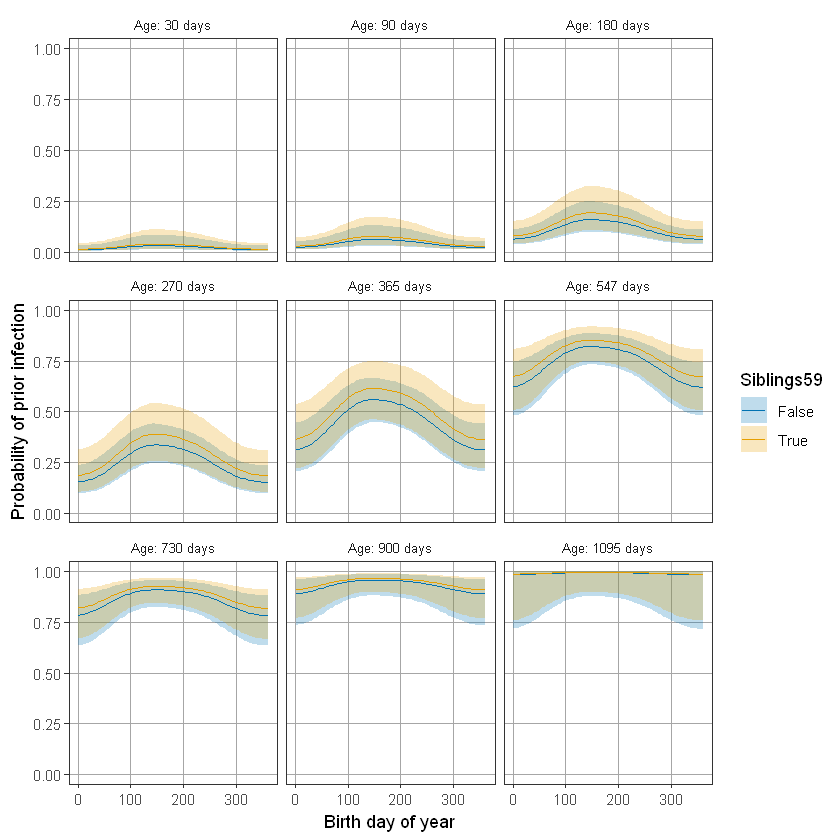

In [20]:
# Additional model 2, with age, birth doy and Siblings59
model2.1 <- gam(
  formula = infection ~ 
    Siblings59 + 
    ti(Birth_doy, bs = "cp", k = 11) + 
    #ti(household04n, bs = "re", k = 10) +
    ti(age_days, bs = "ps", k = 25),# +
  #ti(age_days, bs = "ps", k = 15, by = siblings04),
  knots = list(birth_doy = c(1, 365)),
  family = binomial,
  method = "REML",  #restricted maximum likelihood 
  data = rsv.data)
summary(model2.1)

# Generate some fake data for the model prediction
rsv.preddata <- expand.grid(
  age_days = c(30,90,180,270,365,547,730,900,1095),
  Birth_doy = seq(from = 1, to = 365, by = 5),
  Siblings59 = factor(c('True', 'False')))

# Make predictions for each combination using the GAM model
# Do this in a temporary tibble, because two columns are produced: fit and se.fit
tmp <- predict(
  object = model2.1,
  newdata = rsv.preddata,
  type = "link",
  se.fit = TRUE) %>%
  as_tibble

# Bind tmp to rsv.preddata and calculate the p_inf including 95% lower and upper bound
rsv.doy_age_sib59.preddata <- bind_cols(rsv.preddata, tmp) %>%
  mutate(
    fit_lwr = fit + qnorm(0.025)*se.fit,   
    fit_upr = fit + qnorm(0.975)*se.fit,
    p_inf = fit %>% plogis,                #create vector of probabilities from log odds
    p_inf_lwr = fit_lwr %>% plogis,
    p_inf_upr = fit_upr %>% plogis)

#
# Plot results ----
#

# Plot Supplement Figure
doy_age_sib59 <- ggplot(
  data = rsv.doy_age_sib59.preddata,
  mapping = aes(
    x = Birth_doy, y = p_inf, ymin = p_inf_lwr, ymax = p_inf_upr, 
    group= Siblings59, col= Siblings59, fill = Siblings59)) +
  geom_ribbon(
    alpha = 0.25, colour = NA) +
  geom_line() +
  scale_fill_manual(values=c(color_1, color_2)) + 
  scale_color_manual(values=c(color_1, color_2)) + 
  ylab("Probability of prior infection") +
  xlab("Birth day of year") +
  facet_wrap(
    facets = ~ age_days, labeller = labeller(age_days = 
                                               c("30" = "Age: 30 days",
                                                 "90" = "Age: 90 days",
                                                 "180" = "Age: 180 days",
                                                 "270" = "Age: 270 days",
                                                 "365" = "Age: 365 days",
                                                 "547" = "Age: 547 days",
                                                 "730" = "Age: 730 days",
                                                 "900" = "Age: 900 days",
                                                 "1095" = "Age: 1095 days"))
  )  + theme_bw() + 
  theme(panel.grid.minor = element_blank(),panel.grid.major = element_line(colour = "grey65", size = 0.2),
        strip.background = element_rect(
          color="black", fill="white", linetype = "blank"),
        strip.text = element_text(size=8)
  )

doy_age_sib59
ggsave(file = file.path(PATH, 'age_doy_sib59.svg'), plot = doy_age_sib59)

**Model3 with age, birth doy and nursery**

In [21]:
model3 <- gam(
  formula = infection ~ 
    Nursery + 
    ti(age_days, bs = "ps", k = 25) + 
    ti(Birth_doy, bs = "cp", k = 11),# +
  #ti(contact04, bs = "re", k = 20) +
  #ti(age_days, bs = "ps", k = 25, by = visitnursery_child, m = 1) + 
  #ti(birth_doy, bs = "cp", k = 10, by = visitnursery_child, m = 1),
  # ti(contact04, bs = "re", k = 20, by = siblings04, m = 1), 
  
  knots = list(birth_doy = c(1, 365)),
  family = binomial,
  method = "REML",  #restricted maximum likelihood 
  data = rsv.data)
summary(model3)

Warning message in smooth.construct.tensor.smooth.spec(object, dk$data, dk$knots):
"reparameterization unstable for margin: not done"



Family: binomial 
Link function: logit 

Formula:
infection ~ Nursery + ti(age_days, bs = "ps", k = 25) + ti(Birth_doy, 
    bs = "cp", k = 11)

Parametric coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)   0.8409     1.1559   0.727    0.467    
NurseryTrue   1.1806     0.2521   4.682 2.84e-06 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Approximate significance of smooth terms:
                edf Ref.df  Chi.sq p-value    
ti(age_days)  3.000      3 130.099 < 2e-16 ***
ti(Birth_doy) 2.145     10   9.398 0.00506 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

R-sq.(adj) =  0.568   Deviance explained = 51.1%
-REML = 206.98  Scale est. = 1         n = 616

Saving 6.67 x 6.67 in image



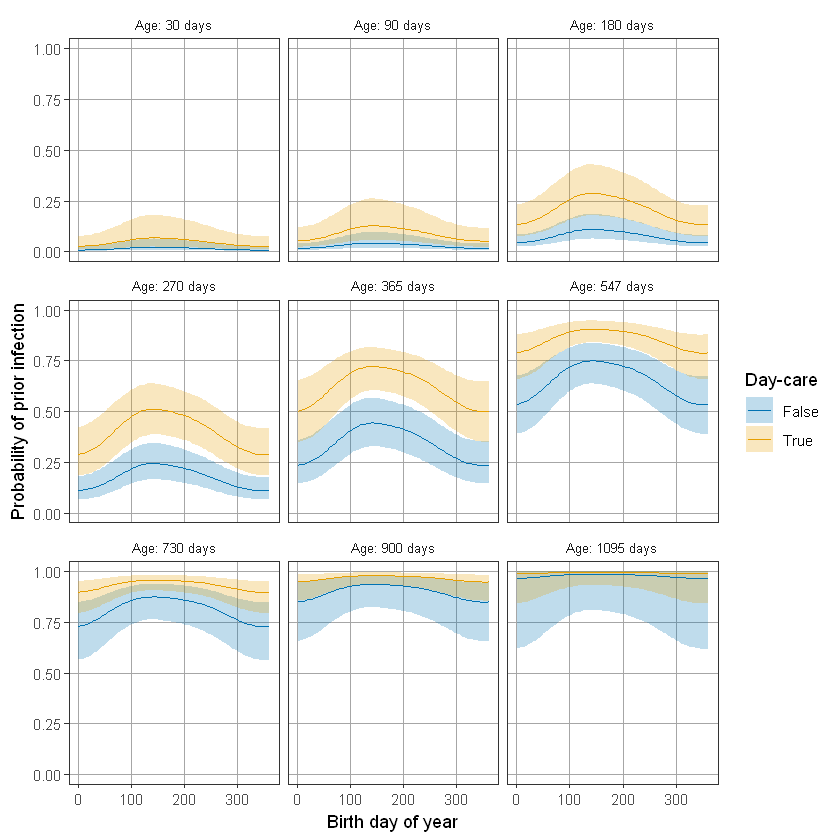

In [22]:
# Generate some fake data for the model prediction
rsv.preddata <- expand.grid(
  age_days = c(30,90,180,270,365,547,730,900,1095),
  Birth_doy = seq(from = 1, to = 365, by = 5),
  Nursery = factor(c('False', 'True')))

# Make predictions for each combination using the GAM model
# Do this in a temporary tibble, because two columns are produced: fit and se.fit
tmp <- predict(
  object = model3,
  newdata = rsv.preddata,
  type = "link",
  se.fit = TRUE) %>%
  as_tibble

# Bind tmp to rsv.preddata and calculate the p_inf including 95% lower and upper bound
rsv.doy_age_nur.preddata <- bind_cols(rsv.preddata, tmp) %>%
  mutate(
    fit_lwr = fit + qnorm(0.025)*se.fit,   
    fit_upr = fit + qnorm(0.975)*se.fit,
    p_inf = fit %>% plogis,                #create vector of probabilities from log odds
    p_inf_lwr = fit_lwr %>% plogis,
    p_inf_upr = fit_upr %>% plogis)

#
# Plot results ----
#

# Plot Supplement Figure
doy_age_nur <- ggplot(
  data = rsv.doy_age_nur.preddata,
  mapping = aes(
    x = Birth_doy, y = p_inf, ymin = p_inf_lwr, ymax = p_inf_upr, 
    group= Nursery, col= Nursery, fill = Nursery)) +
  geom_ribbon(
    alpha = 0.25, colour = NA) +
  geom_line() +
  scale_fill_manual(values=c(color_1, color_2)) + 
  scale_color_manual(values=c(color_1, color_2)) + 
  ylab("Probability of prior infection") +
  xlab("Birth day of year") +
  facet_wrap(
    facets = ~ age_days, labeller = labeller(age_days = 
                                               c("30" = "Age: 30 days",
                                                 "90" = "Age: 90 days",
                                                 "180" = "Age: 180 days",
                                                 "270" = "Age: 270 days",
                                                 "365" = "Age: 365 days",
                                                 "547" = "Age: 547 days",
                                                 "730" = "Age: 730 days",
                                                 "900" = "Age: 900 days",
                                                 "1095" = "Age: 1095 days"))
  ) + theme_bw() + 
  theme(panel.grid.minor = element_blank(),panel.grid.major = element_line(colour = "grey65", size = 0.2),
        strip.background = element_rect(
          color="black", fill="white", linetype = "blank"),
        strip.text = element_text(size=8)
  ) + guides(fill=guide_legend(title="Day-care"), col=guide_legend(title="Day-care"))

doy_age_nur   
ggsave(file = file.path(PATH, 'age_doy_nur.svg'), plot = doy_age_nur)


**Model4 with age, birth doy, Siblings04 and nursery**

Warning message in smooth.construct.tensor.smooth.spec(object, dk$data, dk$knots):
"reparameterization unstable for margin: not done"



Family: binomial 
Link function: logit 

Formula:
infection ~ Nursery + Siblings04 + ti(age_days, bs = "ps", k = 25) + 
    ti(Birth_doy, bs = "cp", k = 11)

Parametric coefficients:
               Estimate Std. Error z value Pr(>|z|)    
(Intercept)      0.5808     1.1755   0.494   0.6212    
NurseryTrue      1.2275     0.2557   4.801 1.58e-06 ***
Siblings04True   0.6034     0.2540   2.376   0.0175 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Approximate significance of smooth terms:
                edf Ref.df  Chi.sq p-value    
ti(age_days)  3.000      3 131.080 < 2e-16 ***
ti(Birth_doy) 2.172     10   9.976 0.00376 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

R-sq.(adj) =  0.571   Deviance explained = 51.8%
-REML =  204.5  Scale est. = 1         n = 616

Saving 6.67 x 6.67 in image



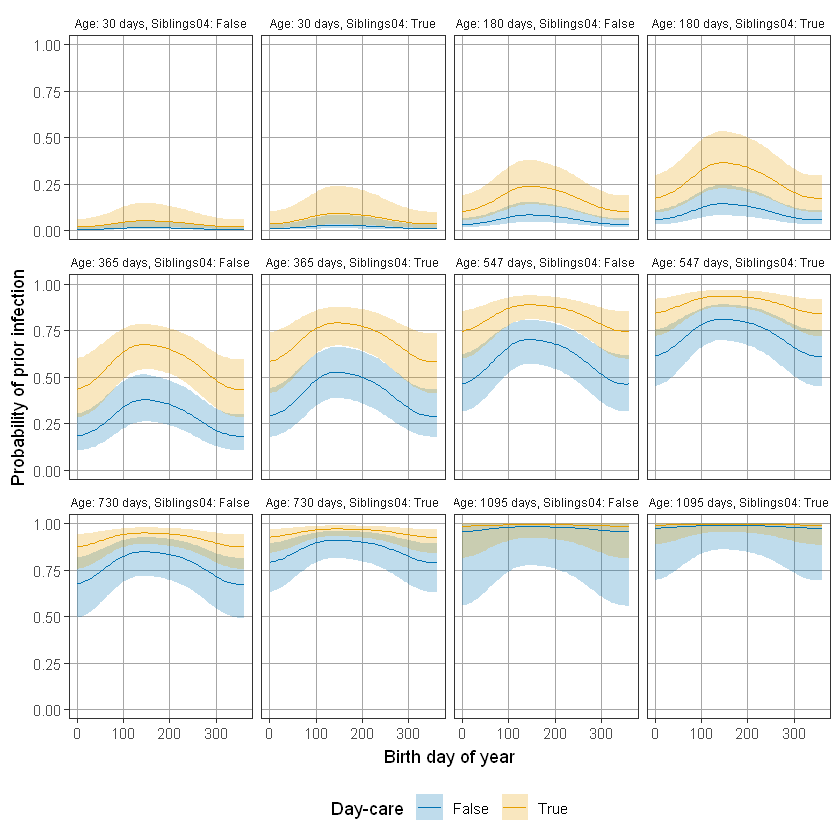

In [23]:
model4 <- gam(
  formula = infection ~ 
    Nursery + 
    Siblings04 +
    ti(age_days, bs = "ps", k = 25) + 
    ti(Birth_doy, bs = "cp", k = 11),# +
  #ti(contact04, bs = "re", k = 10) +
  #ti(age_days, bs = "ps", k = 25, by = siblings04, m = 1) + 
  #ti(birth_doy, bs = "cp", k = 10, by = siblings04, m = 1) +
  # ti(contact04, bs = "re", k = 10, by = siblings04, m = 1) + 
  #ti(age_days, bs = "ps", k = 25, by = visitnursery_child, m = 1) + 
  #ti(birth_doy, bs = "cp", k = 10, by = visitnursery_child, m = 1),# +
  # ti(contact04, bs = "re", k = 10, by = visitnursery_child, m = 1),# 
  
  knots = list(Birth_doy = c(1, 365)),
  family = binomial,
  method = "REML",  #restricted maximum likelihood 
  data = rsv.data)
summary(model4)

# Generate some fake data for the model prediction
rsv.preddata <- expand.grid(
  age_days = c(30,180,365,547,730,1095),
  Birth_doy = seq(from = 1, to = 365, by = 5),
  Siblings04 = factor(c('True', 'False')),
  Nursery = factor(c('True', 'False')))

# Make predictions for each combination using the GAM model
# Do this in a temporary tibble, because two columns are produced: fit and se.fit
tmp <- predict(
  object = model4,
  newdata = rsv.preddata,
  type = "link",
  se.fit = TRUE) %>%
  as_tibble

# Bind tmp to rsv.preddata and calculate the p_inf including 95% lower and upper bound
rsv.doy_age_sib_nur.preddata <- bind_cols(rsv.preddata, tmp) %>%
  mutate(
    fit_lwr = fit + qnorm(0.025)*se.fit,   
    fit_upr = fit + qnorm(0.975)*se.fit,
    p_inf = fit %>% plogis,                #create vector of probabilities from log odds
    p_inf_lwr = fit_lwr %>% plogis,
    p_inf_upr = fit_upr %>% plogis)

#
# Plot results ----
#

# Plot Figure 4
doy_age_sib_nur <- ggplot(
  data = rsv.doy_age_sib_nur.preddata,
  mapping = aes(
    x = Birth_doy, y = p_inf, ymin = p_inf_lwr, ymax = p_inf_upr, 
    group=Nursery , col= Nursery, fill = Nursery)) +
  geom_ribbon(
    alpha = 0.25, colour = NA) +
  geom_line() +
  scale_fill_manual(values=c(color_1, color_2)) + 
  scale_color_manual(values=c(color_1, color_2)) + 
  ylab("Probability of prior infection") +
  xlab("Birth day of year") +
  facet_wrap(
    facets = ~ age_days + Siblings04, labeller = labeller(age_days = 
                                                            c("30" = "Age: 30 days",
                                                              "90" = "Age: 90 days",
                                                              "180" = "Age: 180 days",
                                                              "270" = "Age: 270 days",
                                                              "365" = "Age: 365 days",
                                                              "547" = "Age: 547 days",
                                                              "730" = "Age: 730 days",
                                                              "900" = "Age: 900 days",
                                                              "1095" = "Age: 1095 days"),
                                                          Siblings04 = c("False" = "Siblings04: False",
                                                                         "True" = "Siblings04: True"), .multi_line = FALSE)
  ) + theme_bw() + 
  theme(panel.grid.minor = element_blank(), #remove grid lines between ticks
        panel.grid.major = element_line(colour = "grey65", size = 0.2), #set size and color of grid lines
        strip.background = element_rect(color="black", fill="white", linetype = "blank"), #set the background
        legend.position = "bottom", #remove legend
        strip.text = element_text(size=7.4) #set text size for text above the plots
  ) + guides(fill=guide_legend(title="Day-care"), col=guide_legend(title="Day-care"))

doy_age_sib_nur
ggsave(file = file.path(PATH, 'age_doy_sib_nur.svg'), plot = doy_age_sib_nur)


## Table 1 ##

In [46]:
# Table 1
rsv.preddata <- expand.grid(
  age_days = c(30,365,730),
  Birth_doy = c(1,182), # 1 Jan, 1 July
  Siblings04 = factor(c('True', 'False')),
  Nursery = factor(c('True', 'False')))

# Make predictions for each combination using the GAM model
# Do this in a temporary tibble, because two columns are produced: fit and se.fit
tmp <- predict(
  object = model4,
  newdata = rsv.preddata,
  type = "link",
  se.fit = TRUE) %>%
  as_tibble

# Bind tmp to rsv.preddata and calculate the p_inf including 95% lower and upper bound
rsv.doy_age_sib_nur.preddata <- bind_cols(rsv.preddata, tmp) %>%
  mutate(
    fit_lwr = fit + qnorm(0.025)*se.fit,   
    fit_upr = fit + qnorm(0.975)*se.fit,
    p_inf = fit %>% plogis,                #create vector of probabilities from log odds
    p_inf_lwr = fit_lwr %>% plogis,
    p_inf_upr = fit_upr %>% plogis)

table_model4 <- rsv.doy_age_sib_nur.preddata %>% 
  mutate(
    p_inf = p_inf,# %>% round(digits = 3),
    p_inf_lwr = p_inf_lwr,# %>% round(digits = 3),
    p_inf_upr = p_inf_upr,# %>% round(digits = 3),
    n = rsv.data %>% nrow
  ) %>% 
  select(`Age (days)` = age_days, 
         DOY = Birth_doy,
         Siblings04,
         `Day-care` = Nursery,
         n,
         `Probability of prior infection` = p_inf,
         `Lower` = p_inf_lwr,
         `Upper` = p_inf_upr) %>% 
  arrange(`Age (days)`, DOY, Siblings04) %>% 
  write_xlsx(path = "tabel_model4.xlsx")

In [47]:
# table 1
table_complete <- table_model4 %>% 
  left_join(table_model1, by = c("Age (days)", "DOY")) %>% 
  left_join(table_model2, by = c("Age (days)", "DOY", "Siblings04")) %>% 
  left_join(table_model3, by = c("Age (days)", "DOY", "Day-care")) %>% 
  select(`Age (days)`, DOY, `Probability of prior infection m1`, `Lower m1`, `Upper m1`,
         `Siblings04`, `Probability of prior infection m2`, `Lower m2`, `Upper m2`,
         `Day-care`, `Probability of prior infection m3`, `Lower m3`, `Upper m3`,
         `Probability of prior infection m4`, `Lower m4`, `Upper m4`) %>% 
  write_xlsx(path = "voorbeeld_tabel_versie2.xlsx")

ERROR: Error in UseMethod("left_join"): no applicable method for 'left_join' applied to an object of class "character"


In [48]:
rm(age_groups)

Warning message in rm(age_groups):
"object 'age_groups' not found"


**Examples/numbers given in the manuscipt**

In [27]:
#The examples/numbers given in the manuscript
# Abstract summer vs winter 
rsv.doy_age.preddata[rsv.doy_age.preddata$age_days == 365 & rsv.doy_age.preddata$Birth_doy == 1,c('p_inf', 'p_inf_lwr', 'p_inf_upr')]
rsv.doy_age.preddata[rsv.doy_age.preddata$age_days == 365 & rsv.doy_age.preddata$Birth_doy == 182,c('p_inf', 'p_inf_lwr', 'p_inf_upr')]

,p_inf,p_inf_lwr,p_inf_upr
,<dbl>,<dbl>,<dbl>
8,0.3239709,0.2165643,0.4537914


,p_inf,p_inf_lwr,p_inf_upr
,<dbl>,<dbl>,<dbl>
2180,0.5585054,0.4529868,0.6589923


In [28]:
# Abstract siblings04 
rsv.doy_age_sib.preddata[rsv.doy_age_sib.preddata$age_days == 365 & 
                           rsv.doy_age_sib.preddata$Birth_doy == 181 & 
                           rsv.doy_age_sib.preddata$Siblings04 == 'True',c('p_inf', 'p_inf_lwr', 'p_inf_upr')]
rsv.doy_age_sib.preddata[rsv.doy_age_sib.preddata$age_days == 365 & 
                           rsv.doy_age_sib.preddata$Birth_doy == 181 & 
                           rsv.doy_age_sib.preddata$Siblings04 == 'False',c('p_inf', 'p_inf_lwr', 'p_inf_upr')]

,p_inf,p_inf_lwr,p_inf_upr
,<dbl>,<dbl>,<dbl>
329,0.6338039,0.5076194,0.7439615


,p_inf,p_inf_lwr,p_inf_upr
,<dbl>,<dbl>,<dbl>
986,0.5092355,0.394448,0.6230572


In [29]:
# Abstract nursery
rsv.doy_age_nur.preddata[rsv.doy_age_nur.preddata$age_days == 365 & 
                           rsv.doy_age_nur.preddata$Birth_doy == 181 & 
                           rsv.doy_age_nur.preddata$Nursery == 'True',]
rsv.doy_age_nur.preddata[rsv.doy_age_nur.preddata$age_days == 365 & 
                           rsv.doy_age_nur.preddata$Birth_doy == 181 & 
                           rsv.doy_age_nur.preddata$Nursery == 'False',c('p_inf', 'p_inf_lwr', 'p_inf_upr')]

,age_days,Birth_doy,Nursery,fit,se.fit,fit_lwr,fit_upr,p_inf,p_inf_lwr,p_inf_upr
,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
986,365,181,True,0.8876548,0.264588,0.3690718,1.406238,0.708406,0.5912347,0.8031719


,p_inf,p_inf_lwr,p_inf_upr
,<dbl>,<dbl>,<dbl>
329,0.4272926,0.314542,0.5481398


** Results July vs January **

In [30]:
#half a year
rsv.doy_age.preddata[rsv.doy_age.preddata$age_days == 182 & rsv.doy_age.preddata$Birth_doy == 15,c('p_inf', 'p_inf_lwr', 'p_inf_upr')] #jan. 15
rsv.doy_age.preddata[rsv.doy_age.preddata$age_days == 182 & rsv.doy_age.preddata$Birth_doy == 196,c('p_inf', 'p_inf_lwr', 'p_inf_upr')]# juli 15

p_inf,p_inf_lwr,p_inf_upr
<dbl>,<dbl>,<dbl>


p_inf,p_inf_lwr,p_inf_upr
<dbl>,<dbl>,<dbl>


In [31]:
# one year
rsv.doy_age.preddata[rsv.doy_age.preddata$age_days == 365 & rsv.doy_age.preddata$Birth_doy == 15,c('p_inf', 'p_inf_lwr', 'p_inf_upr')] #jan. 15
rsv.doy_age.preddata[rsv.doy_age.preddata$age_days == 365 & rsv.doy_age.preddata$Birth_doy == 196,c('p_inf', 'p_inf_lwr', 'p_inf_upr')]# juli 15

,p_inf,p_inf_lwr,p_inf_upr
,<dbl>,<dbl>,<dbl>
176,0.3335606,0.2237074,0.4650425


,p_inf,p_inf_lwr,p_inf_upr
,<dbl>,<dbl>,<dbl>
2348,0.5486712,0.4426685,0.6504337


**Results siblings04**

In [32]:
# age half a year
rsv.doy_age_sib.preddata[rsv.doy_age_sib.preddata$age_days == 180 & 
                           rsv.doy_age_sib.preddata$Birth_doy == 196 & 
                           rsv.doy_age_sib.preddata$Siblings04 == 'True',c('p_inf', 'p_inf_lwr', 'p_inf_upr')]
rsv.doy_age_sib.preddata[rsv.doy_age_sib.preddata$age_days == 180 & 
                           rsv.doy_age_sib.preddata$Birth_doy == 196 & 
                           rsv.doy_age_sib.preddata$Siblings04 == 'False',c('p_inf', 'p_inf_lwr', 'p_inf_upr')]

,p_inf,p_inf_lwr,p_inf_upr
,<dbl>,<dbl>,<dbl>
354,0.1950232,0.1186456,0.3036302


,p_inf,p_inf_lwr,p_inf_upr
,<dbl>,<dbl>,<dbl>
1011,0.1268259,0.07516871,0.2060728


In [33]:
# age 1 year
rsv.doy_age_sib.preddata[rsv.doy_age_sib.preddata$age_days == 365 & 
                           rsv.doy_age_sib.preddata$Birth_doy == 196 & 
                           rsv.doy_age_sib.preddata$Siblings04 == 'True',c('p_inf', 'p_inf_lwr', 'p_inf_upr')]
rsv.doy_age_sib.preddata[rsv.doy_age_sib.preddata$age_days == 365 & 
                           rsv.doy_age_sib.preddata$Birth_doy == 196 & 
                           rsv.doy_age_sib.preddata$Siblings04 == 'False',c('p_inf', 'p_inf_lwr', 'p_inf_upr')]

,p_inf,p_inf_lwr,p_inf_upr
,<dbl>,<dbl>,<dbl>
356,0.6243597,0.4969884,0.7365737


,p_inf,p_inf_lwr,p_inf_upr
,<dbl>,<dbl>,<dbl>
1013,0.4991175,0.3845249,0.6138028


**Results day-care**

In [34]:
# age half a year
rsv.doy_age_nur.preddata[rsv.doy_age_nur.preddata$age_days == 180 & 
                           rsv.doy_age_nur.preddata$Birth_doy == 196 & 
                           rsv.doy_age_nur.preddata$Nursery == 'True',c('p_inf', 'p_inf_lwr', 'p_inf_upr')]
rsv.doy_age_nur.preddata[rsv.doy_age_nur.preddata$age_days == 180 & 
                           rsv.doy_age_nur.preddata$Birth_doy == 196 & 
                           rsv.doy_age_nur.preddata$Nursery == 'False',c('p_inf', 'p_inf_lwr', 'p_inf_upr')]

,p_inf,p_inf_lwr,p_inf_upr
,<dbl>,<dbl>,<dbl>
1011,0.2647381,0.164735,0.3966219


,p_inf,p_inf_lwr,p_inf_upr
,<dbl>,<dbl>,<dbl>
354,0.09956686,0.05711593,0.1679491


In [35]:
# age a year
rsv.doy_age_nur.preddata[rsv.doy_age_nur.preddata$age_days == 365 & 
                           rsv.doy_age_nur.preddata$Birth_doy == 196 & 
                           rsv.doy_age_nur.preddata$Nursery == 'True',c('p_inf', 'p_inf_lwr', 'p_inf_upr')]
rsv.doy_age_nur.preddata[rsv.doy_age_nur.preddata$age_days == 365 & 
                           rsv.doy_age_nur.preddata$Birth_doy == 196 & 
                           rsv.doy_age_nur.preddata$Nursery == 'False',c('p_inf', 'p_inf_lwr', 'p_inf_upr')]

,p_inf,p_inf_lwr,p_inf_upr
,<dbl>,<dbl>,<dbl>
1013,0.698531,0.5799662,0.7954329


,p_inf,p_inf_lwr,p_inf_upr
,<dbl>,<dbl>,<dbl>
356,0.4157492,0.3037976,0.5371272


**HR vs LR**

In [36]:
# at half a year
rsv.doy_age_sib_nur.preddata[rsv.doy_age_sib_nur.preddata$age_days == 180 & 
                               rsv.doy_age_sib_nur.preddata$Birth_doy == 196 & 
                               rsv.doy_age_sib_nur.preddata$Siblings04 == 'True' &
                               rsv.doy_age_sib_nur.preddata$Nursery == 'True',c('p_inf', 'p_inf_lwr', 'p_inf_upr')]

rsv.doy_age_sib_nur.preddata[rsv.doy_age_sib_nur.preddata$age_days == 180 & 
                               rsv.doy_age_sib_nur.preddata$Birth_doy == 196 & 
                               rsv.doy_age_sib_nur.preddata$Siblings04 == 'False' &
                               rsv.doy_age_sib_nur.preddata$Nursery == 'False',c('p_inf', 'p_inf_lwr', 'p_inf_upr')]

p_inf,p_inf_lwr,p_inf_upr
<dbl>,<dbl>,<dbl>


p_inf,p_inf_lwr,p_inf_upr
<dbl>,<dbl>,<dbl>


In [37]:
# at a year
rsv.doy_age_sib_nur.preddata[rsv.doy_age_sib_nur.preddata$age_days == 365 & 
                               rsv.doy_age_sib_nur.preddata$Birth_doy == 196 & 
                               rsv.doy_age_sib_nur.preddata$Siblings04 == 'True' &
                               rsv.doy_age_sib_nur.preddata$Nursery == 'True',c('p_inf', 'p_inf_lwr', 'p_inf_upr')]

rsv.doy_age_sib_nur.preddata[rsv.doy_age_sib_nur.preddata$age_days == 365 & 
                               rsv.doy_age_sib_nur.preddata$Birth_doy == 196 & 
                               rsv.doy_age_sib_nur.preddata$Siblings04 == 'False' &
                               rsv.doy_age_sib_nur.preddata$Nursery == 'False',c('p_inf', 'p_inf_lwr', 'p_inf_upr')]

p_inf,p_inf_lwr,p_inf_upr
<dbl>,<dbl>,<dbl>


p_inf,p_inf_lwr,p_inf_upr
<dbl>,<dbl>,<dbl>


**Discussion**

In [39]:
#month one summer
rsv.doy_age.preddata[rsv.doy_age.preddata$age_days == 30 & rsv.doy_age.preddata$Birth_doy == 196, c('p_inf', 'p_inf_lwr', 'p_inf_upr')]

,p_inf,p_inf_lwr,p_inf_upr
,<dbl>,<dbl>,<dbl>
2341,0.03021948,0.01101448,0.08019524


In [40]:
#month 24 summer
rsv.doy_age.preddata[rsv.doy_age.preddata$age_days == 395 & rsv.doy_age.preddata$Birth_doy == 196, c('p_inf', 'p_inf_lwr', 'p_inf_upr')]


p_inf,p_inf_lwr,p_inf_upr
<dbl>,<dbl>,<dbl>


In [41]:
# month one winter
rsv.doy_age.preddata[rsv.doy_age.preddata$age_days == 30 & rsv.doy_age.preddata$Birth_doy == 15, c('p_inf', 'p_inf_lwr', 'p_inf_upr')]

,p_inf,p_inf_lwr,p_inf_upr
,<dbl>,<dbl>,<dbl>
169,0.01266695,0.004619221,0.03425316


In [42]:
# month 24 winter
rsv.doy_age.preddata[rsv.doy_age.preddata$age_days == 395 & rsv.doy_age.preddata$Birth_doy == 15, c('p_inf', 'p_inf_lwr', 'p_inf_upr')]

p_inf,p_inf_lwr,p_inf_upr
<dbl>,<dbl>,<dbl>


# Model fit measurements #

In [44]:
AIC.data <- data.frame(
  model = c('model1', 'model2', 'model3', 'model4'),
  score = c(model1$aic, model2$aic, model3$aic, model4$aic)
)
BIC.data <- data.frame(
  model = c('model1', 'model2','model3', 'model4'),
  score = c(BIC(model1), BIC(model2), BIC(model3),BIC(model4))
)

r.sq.data <- data.frame(
  model = c('model1', 'model2', 'model3', 'model4'),
  score = c(summary(model1)$r.sq, summary(model2)$r.sq, summary(model3)$r.sq, summary(model4)$r.sq)
)
AIC.data$method <- "AIC"
BIC.data$method <- "BIC"
r.sq.data$method <- "r.sq"
model_scores <- rbind(AIC.data, BIC.data, r.sq.data)

In [45]:
model_scores

model,score,method
<chr>,<dbl>,<chr>
model1,452.3729773,AIC
model2,449.8993555,AIC
model3,431.7232565,AIC
model4,427.8775055,AIC
model1,484.6261305,BIC
model2,486.4854144,BIC
model3,467.8288191,BIC
model4,468.5569981,BIC
model1,0.5375029,r.sq
